# (31) Sim New -- true generative factors

**Motivation**: Tease apart the true generative factors and aux factors, plot their correlation.  <br>

In [1]:
# HIDE CODE


import os, sys
from copy import deepcopy as dc
from os.path import join as pjoin
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-MTMST/_extras')
fig_base_dir = pjoin(git_dir, 'jb-MTMST/figs')
tmp_dir = pjoin(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_MTMST'))
from figures.fighelper import *
from analysis.opticflow import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def _do_pca(a):
    a = flatten_arr(a, ndim_end=0, ndim_start=1)
    u, s, v = sp_lin.svd(a, full_matrices=False, compute_uv=True)
    s *= 100 / s.sum()
    titles = [f"{e:0.1f} %" for e in s]
    pcs = v.reshape(-1, of.dim, of.dim, 2)
    return s, pcs, titles


def _plot_singular_values(s, thres=90):
    fig, axes = create_figure(2, 1, (13, 7), sharex='all')
    axes[0].plot(s, marker='.')
    axes[1].plot(np.cumsum(s), lw=3, marker=None)

    idx = np.where(np.cumsum(s) > thres)[0][0]
    axes[1].axvline(
        idx, color='g', ls=':', lw=1.5,
        label=f'{idx} dimensions',
    )
    axes[1].axhline(
        thres, color='magenta', ls=':', lw=1.5,
        label=f'{thres}% of variance',
    )
    axes[1].legend()

    axes[1].axhline(0, color='k', ls='--', lw=1.2)
    axes[1].axhline(100, color='k', ls='--', lw=1.2)
    axes[1].set_ylim((-3, 103))
    add_grid(axes)
    plt.show()

    
def _sizes_hist(of, obj_i: int = 0):
    fig, ax = create_figure(1, 1, (15, 5))
    size_pix = of.objects[obj_i].size * of.dim ** 2
    sns.histplot(size_pix, bins=np.linspace(0, 80, 81) - 0.5, stat='percent', ax=ax)

    for color, thres in zip(['r', 'k'], [4, 8]):
        lbl = f'{100 * (size_pix < thres).sum() / of.n:0.1f}% smaller than {thres} pixels'
        ax.axvline(thres, color=color, ls='--', lw=1.3, label=lbl)
    ax.legend(fontsize=17)
    plt.show()

## Prepare

In [3]:
fov = 45
dim = 19
res = 2*fov/(dim-1)
kws = dict(
    fov=fov,
    res=res,
    obj_r=0.2,
    obj_bound=0.97,
    obj_zlim=(0.5, 1.0),
    vlim_obj=(0.01, 1.0),
    vlim_slf=(0.01, 1.0),
    residual=False,
)
print(kws)

min_obj_size = 4

{
    'fov': 45,
    'res': 5.0,
    'obj_r': 0.2,
    'obj_bound': 0.97,
    'obj_zlim': (0.5, 1.0),
    'vlim_obj': (0.01, 1.0),
    'vlim_slf': (0.01, 1.0),
    'residual': False
}

## Fxate category (n_obj = 1)

In [4]:
%%time

of = OpticFlow(
    category='fixate',
    n=int(1.3e4),
    n_obj=1,
    **kws,
).compute_coords()
_ = of.compute_flow()
accept = of.filter(min_obj_size)
of.gamma = None

s, pcs, titles = _do_pca(of.alpha_dot[accept])

CPU times: user 15.9 s, sys: 682 ms, total: 16.6 s
Wall time: 10.3 s


In [5]:
accept.sum()

10749

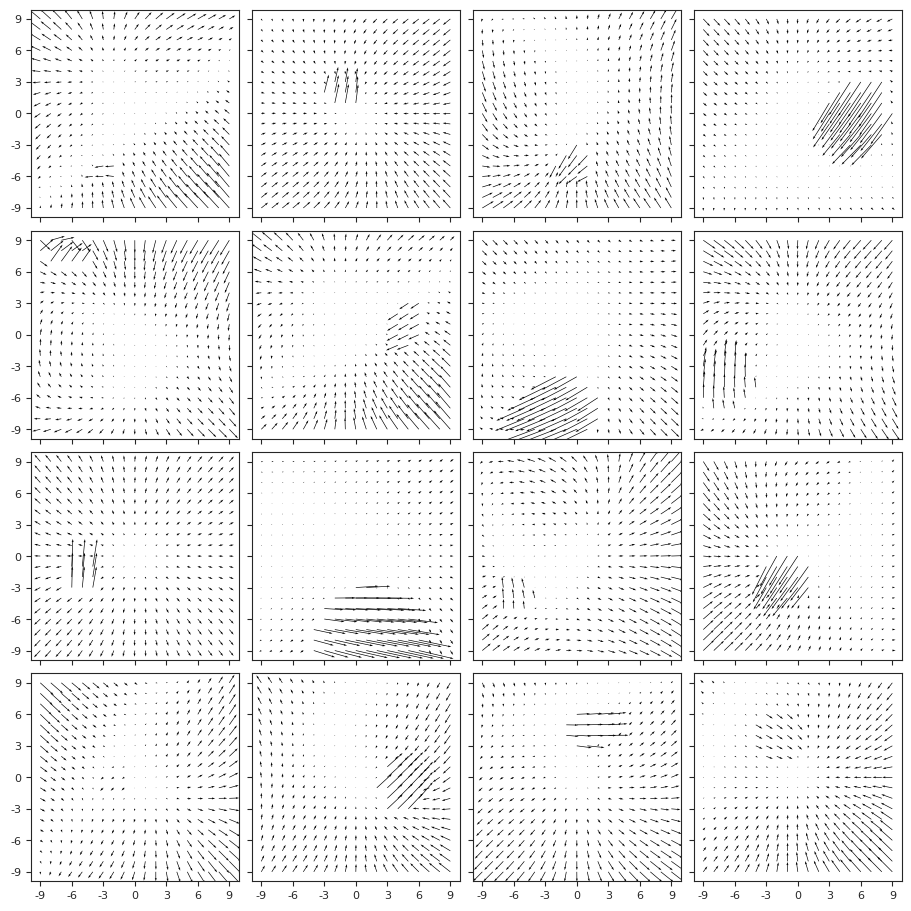

In [6]:
_ = show_opticflow(of.alpha_dot[accept], scale=None)

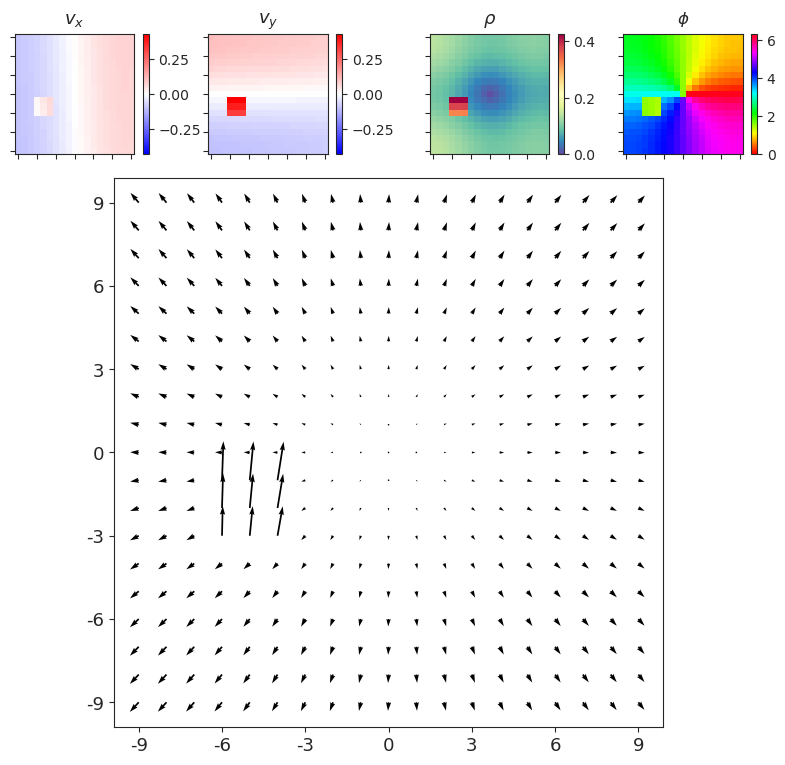

In [7]:
_ = show_opticflow_full(of.alpha_dot[accept][8], scale=6)

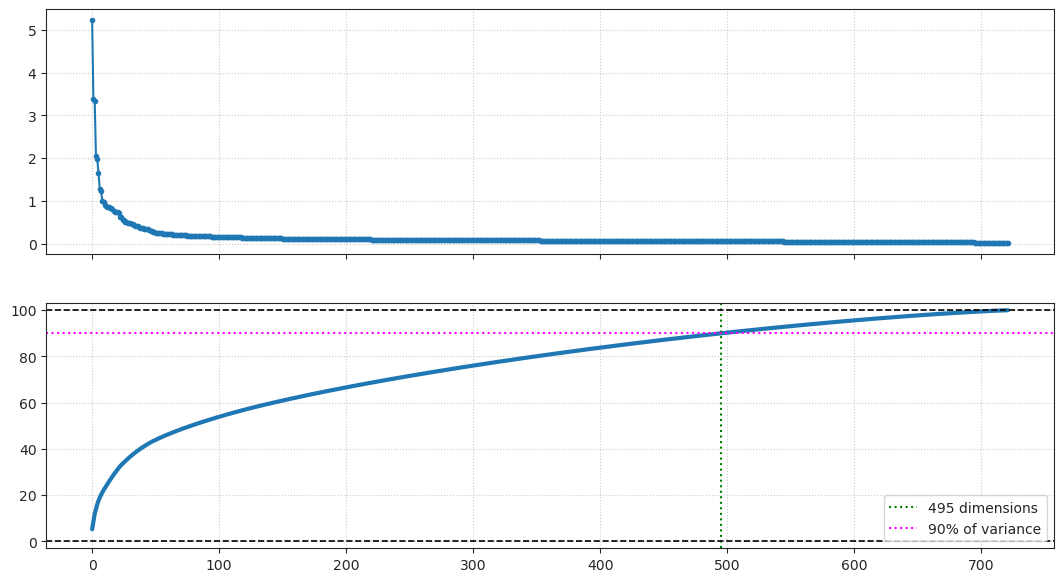

In [8]:
_plot_singular_values(s)

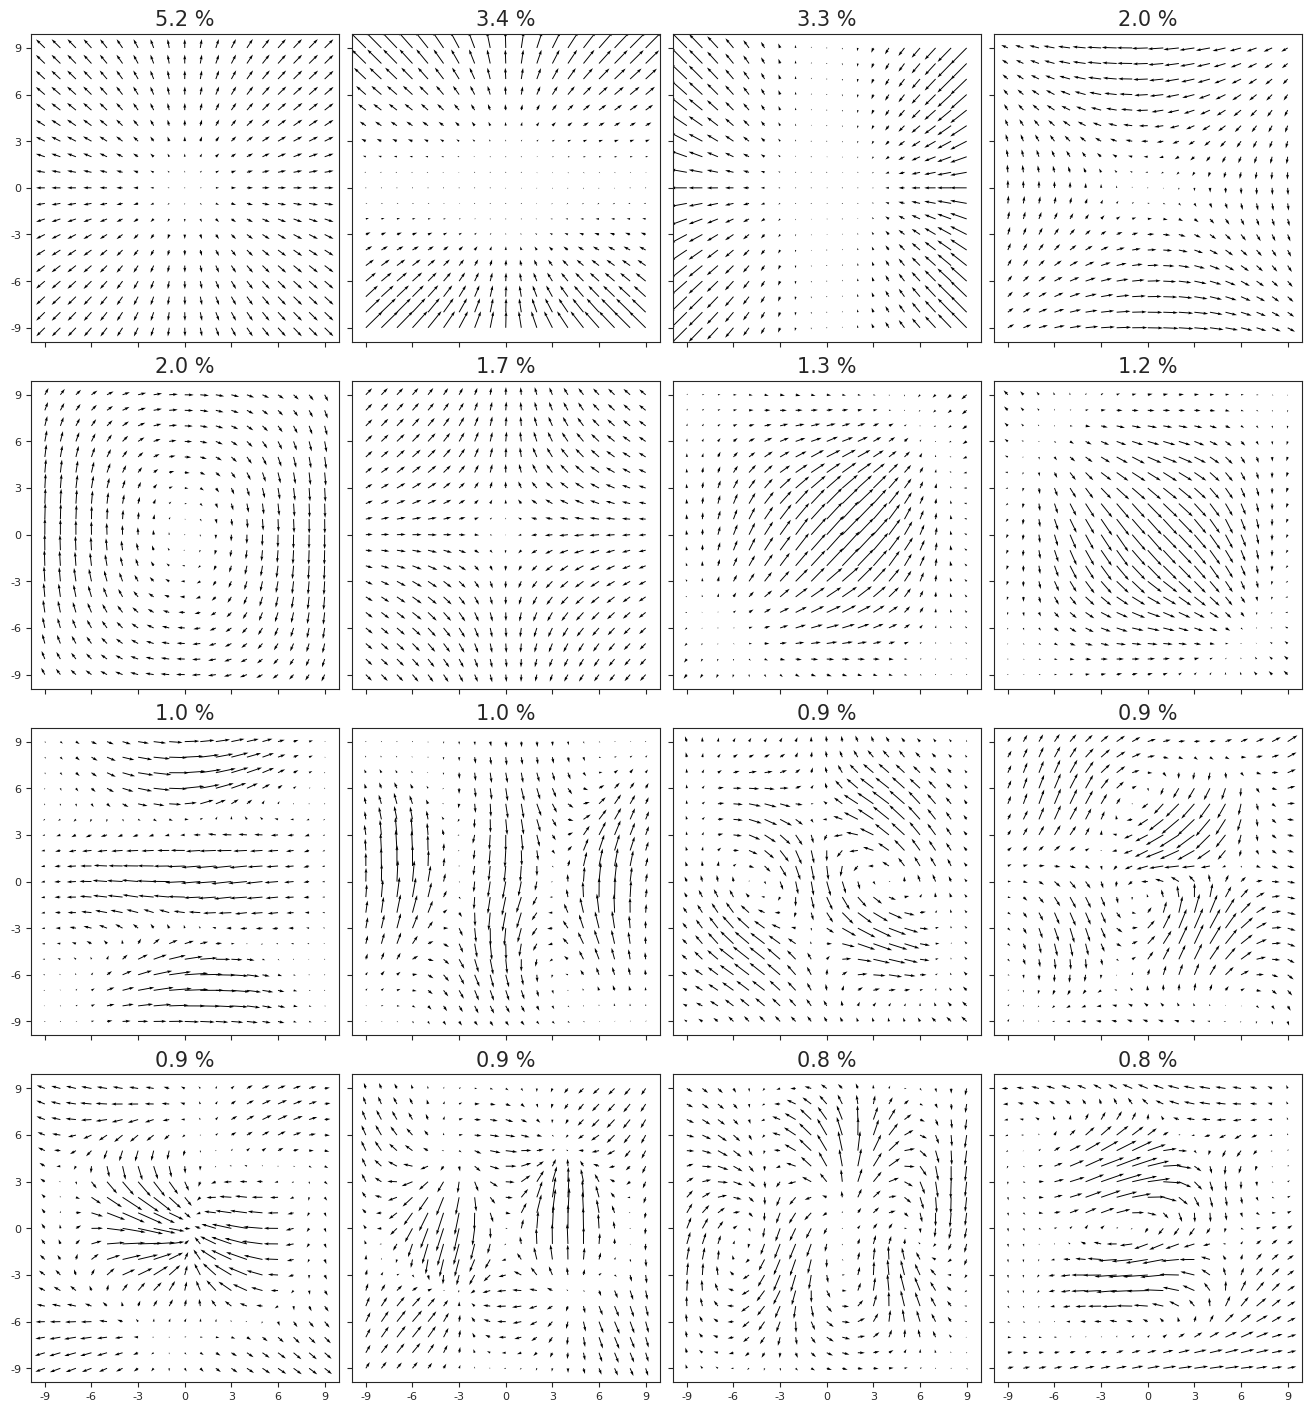

In [9]:
show_opticflow(pcs, num=4, titles=titles, scale=None, figsize=(13, 14));

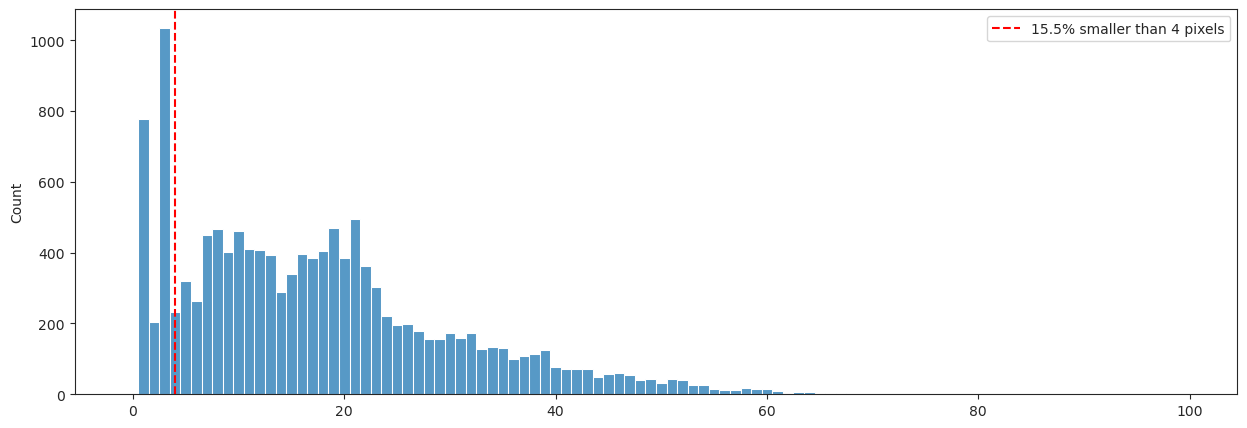

In [10]:
fig, ax = create_figure(1,1,(15, 5))
size_pix = of.objects[0].size * of.dim ** 2
sns.histplot(size_pix, bins=np.linspace(0, 100, 101) - 0.5, ax=ax)

thres = 4
lbl = f'{100 * (size_pix < thres).sum() / of.n:0.1f}% smaller than {thres} pixels'
ax.axvline(thres, color='r', ls='--', label=lbl)
ax.legend();

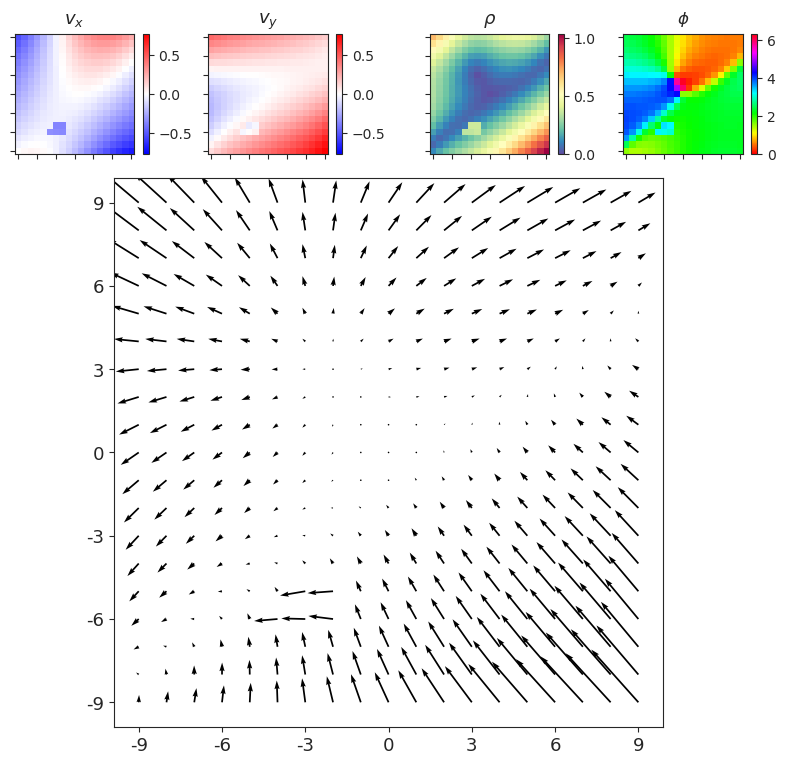

In [11]:
i = np.argmin(size_pix[accept])
_ = show_opticflow_full(of.alpha_dot[accept][i], scale=8)

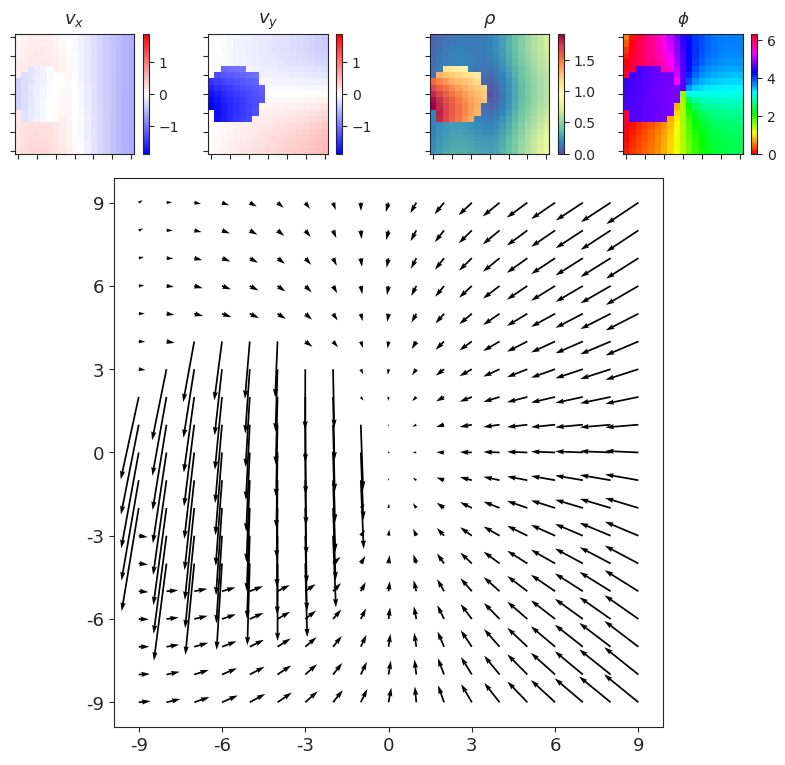

In [12]:
i = np.argsort(size_pix[accept])[-3]
_ = show_opticflow_full(of.alpha_dot[accept][i], scale=10)

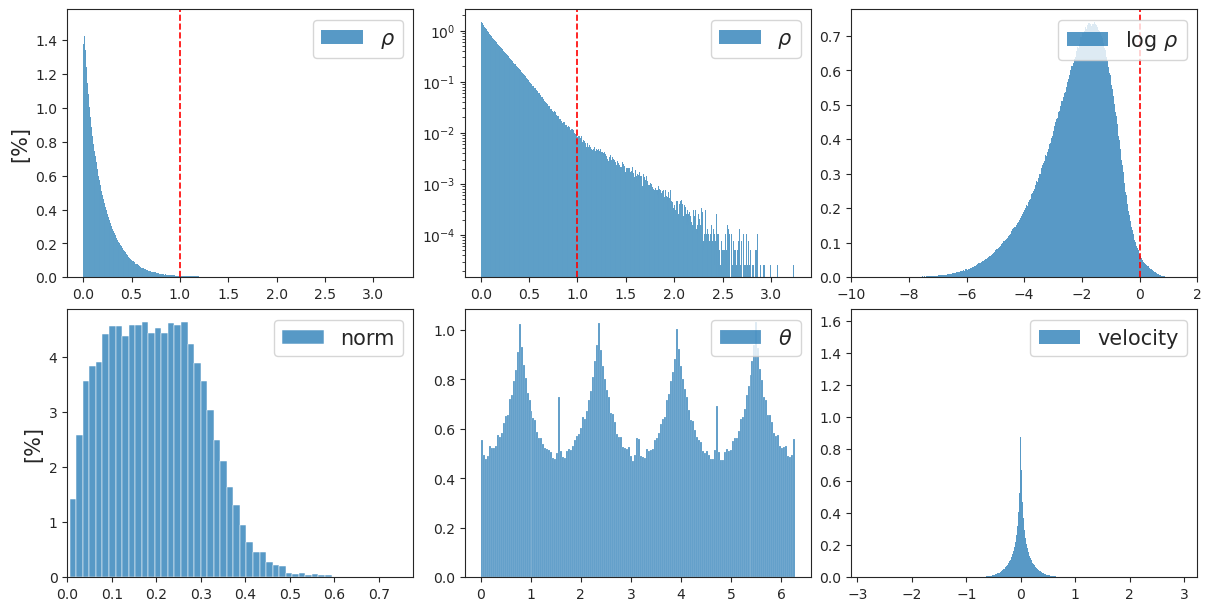

CPU times: user 22.6 s, sys: 816 ms, total: 23.4 s
Wall time: 23.4 s


In [13]:
%%time

_ = plot_opticflow_hist(of.alpha_dot[accept])

## main (self):

of.fix.shape, of.v_slf.shape

## main (obj):

of.objects[0].alpha, of.objects[0].r[:, 0]

## secondary:

of.objects[0].r[:, 1:], delta_x = of.objects[0].pos - of.fix, delta_v = of.objects[0].v - of.v_slf

## emergent:

of.objects[0].size, both v's in polar coordinates, magnitude of delta v in polar coordinates

In [16]:
sp_stats.pearsonr(of.objects[0].v[:, 0] - of.v_slf[:, 0], of.v_slf[:, 0])

(-0.705694279746587, 0.0)

In [40]:
# true generative factors

factors = {
    'fix_x': of.fix[:, 0],
    'fix_y': of.fix[:, 1],
    'slf_v_x': of.v_slf[:, 0],
    'slf_v_y': of.v_slf[:, 1],
    'slf_v_z': of.v_slf[:, 2],
    'obj0_alpha_x': of.objects[0].alpha[:, 0],
    'obj0_alpha_y': of.objects[0].alpha[:, 1],
    'obj0_dist': of.objects[0].r[:, 0],
    'obj0_v_x': of.objects[0].v[:, 0],
    'obj0_v_y': of.objects[0].v[:, 1],
    'obj0_v_z': of.objects[0].v[:, 2],
}


# auxiliary factors

delta_x = of.objects[0].pos - of.fix
delta_v = of.objects[0].v - of.v_slf

v_slf_polar = cart2polar(of.v_slf)
dv_polar = cart2polar(delta_v)
v_obj_polar = cart2polar(of.objects[0].v)

factors_aux = {
    'slf_v_mag': v_slf_polar[:, 0],
    'slf_v_theta': v_slf_polar[:, 1],
    'slf_v_phi': v_slf_polar[:, 2],
    
    'obj0_size': of.objects[0].size,
    'obj0_theta': of.objects[0].r[:, 1],
    'obj0_phi': of.objects[0].r[:, 2],

    'obj0_x': of.objects[0].pos[:, 0],
    'obj0_y': of.objects[0].pos[:, 1],
    'obj0_z': of.objects[0].pos[:, 2],

    'obj0_dx': delta_x[:, 0],
    'obj0_dy': delta_x[:, 1],
    'obj0_dz': delta_x[:, 2],

    'obj0_v_mag': v_obj_polar[:, 0],
    'obj0_v_theta': v_obj_polar[:, 1],
    'obj0_v_phi': v_obj_polar[:, 2],

    'obj0_dv_x': delta_v[:, 0],
    'obj0_dv_y': delta_v[:, 1],
    'obj0_dv_z': delta_v[:, 2],

    'obj0_dv_mag': dv_polar[:, 0],
    'obj0_dv_theta': dv_polar[:, 1],
    'obj0_dv_phi': dv_polar[:, 2],
}

In [41]:
g = np.stack(list(factors.values()))
rho = 1 - sp_dist.squareform(sp_dist.pdist(
    g, metric='correlation'))
np.fill_diagonal(rho, 0)

g.shape, rho.shape

((11, 13000), (11, 11))

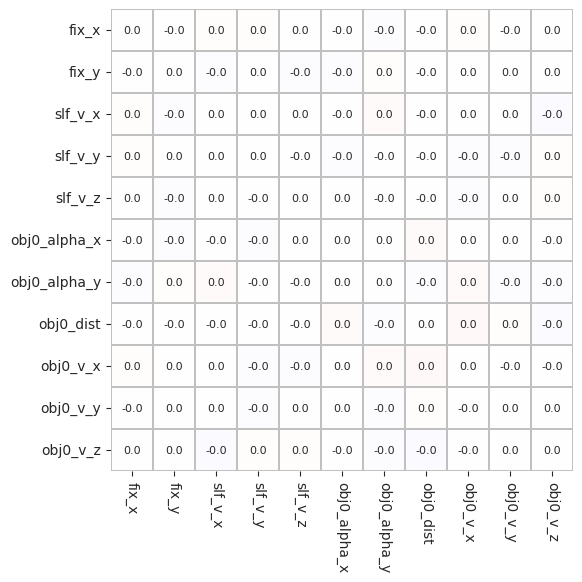

In [42]:
kws = dict(
    xticklabels=list(factors.keys()),
    yticklabels=list(factors.keys()),
    tick_labelsize_x=10,
    tick_labelsize_y=10,
    figsize=(9, 6),
    cbar=False,
)
show_heatmap(rho, **kws);

In [43]:
g = np.stack(list(factors_aux.values()))
rho = 1 - sp_dist.squareform(sp_dist.pdist(
    g, metric='correlation'))
np.fill_diagonal(rho, 0)

g.shape, rho.shape

((21, 13000), (21, 21))

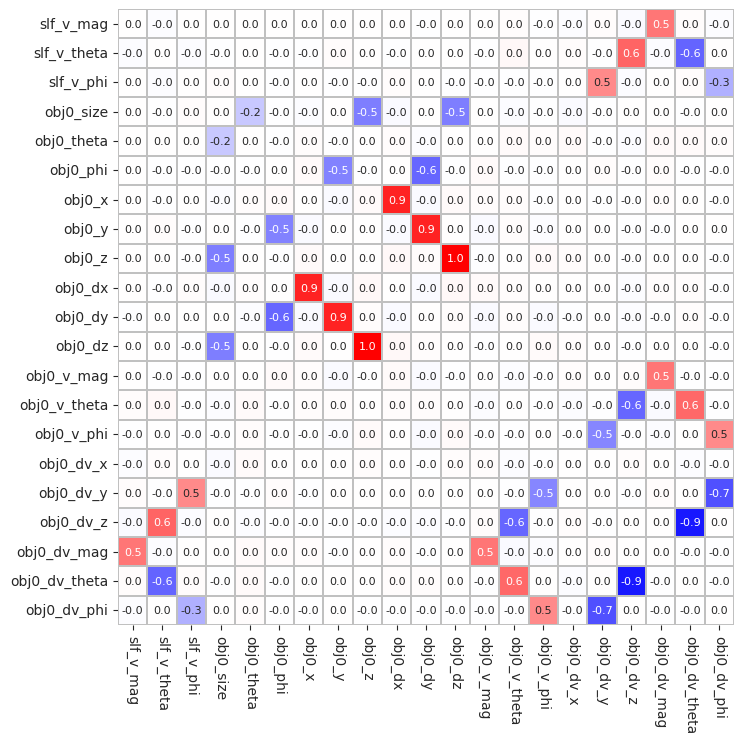

In [44]:
kws = dict(
    xticklabels=list(factors_aux.keys()),
    yticklabels=list(factors_aux.keys()),
    tick_labelsize_x=10,
    tick_labelsize_y=10,
    figsize=(10, 8),
    cbar=False,
)
show_heatmap(rho, **kws);

In [45]:
g = np.concatenate([
    np.stack(list(factors.values())),
    np.stack(list(factors_aux.values())),
])
rho = 1 - sp_dist.squareform(sp_dist.pdist(
    g, metric='correlation'))
np.fill_diagonal(rho, 0)

g.shape, rho.shape

((32, 13000), (32, 32))

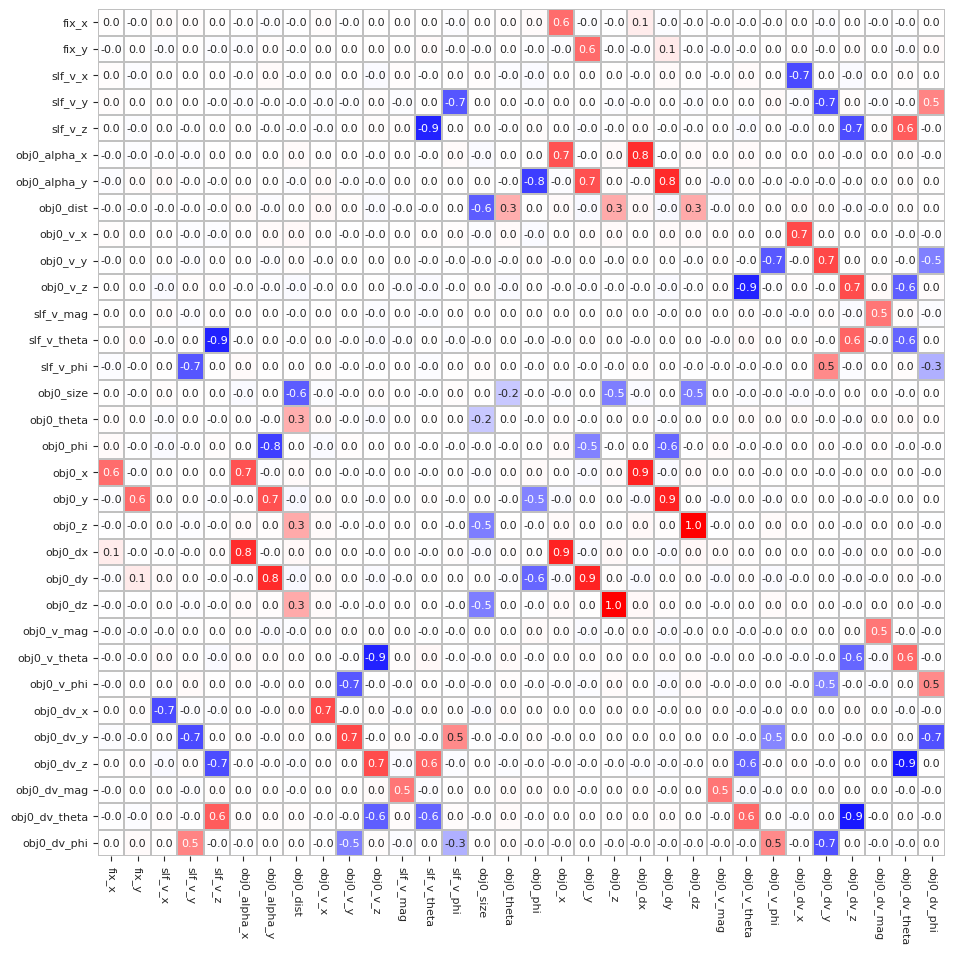

In [46]:
kws = dict(
    xticklabels=list(factors.keys()) + list(factors_aux.keys()),
    yticklabels=list(factors.keys()) + list(factors_aux.keys()),
    tick_labelsize_x=8,
    tick_labelsize_y=8,
    figsize=(13, 11),
    cbar=False,
)
show_heatmap(rho, **kws);

## From the other one:

In [ ]:


of.v_slf.shape

of.objects[0].pos.shape, of.objects[0].v.shape

of.objects[0].alpha.shape, of.objects[0].r.shape

of.objects[0].size.shape

sns.histplot(of.objects[0].size * of.dim ** 2)

fig, ax = create_figure()
sns.histplot(
    x=of.objects[0].alpha[:, 0],
    y=of.objects[0].alpha[:, 1],
    ax=ax,
)
ax_square(ax)

fig, ax = create_figure()
sns.histplot(
    x=of.objects[0].pos[:, 0],
    y=of.objects[0].pos[:, 1],
    ax=ax,
)
ax_square(ax)

sns.histplot(of.objects[0].pos[:, 2])

sns.histplot(of.objects[0].size * of.dim ** 2)

sns.histplot(of.objects[0].r[:, 0])

sns.histplot(of.objects[0].r[:, 1])

sns.histplot(of.objects[0].r[:, 2])



sns.histplot(of.objects[0].v.ravel())

sns.histplot(cart2polar(of.objects[0].v)[:, 2])





zzz = of.z_env[accept].copy()
zzz[zzz == 1] = 0

plt.imshow(zzz.mean(0))



